In [16]:
import numpy as np

from keras.datasets import reuters
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
import keras

import matplotlib.pyplot as plt

In [17]:
# to avoid a cuBLAS error, per https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Reuters - multi-classification (45 classes, one per each article)

In [23]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((8982,), (8982,), (2246,), (2246,))

In [24]:
len(train_data[10])

31

In [5]:
train_data[10][:10]

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14]

In [6]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [25]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [26]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

x_train.shape, x_test.shape

((8982, 10000), (2246, 10000))

In [27]:
x_train[10]

array([0., 1., 0., ..., 0., 0., 0.])

In [28]:
train_labels[10]

3

In [29]:
np.unique(train_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

In [30]:
one_hot_train_labels = keras.utils.np_utils.to_categorical(train_labels)
one_hot_test_labels = keras.utils.np_utils.to_categorical(test_labels)

one_hot_train_labels.shape, one_hot_test_labels.shape

((8982, 46), (2246, 46))

In [31]:
one_hot_train_labels[10]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

We have 45 possible outputs now, so we don't want to use the same 16-dimensional layers we used for a binary classification problem, because crushing data down into that many representations could leave us not enough info when we want to make the final prediction. Instead, we'll use 64-D layers. 

In [32]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

"The last layer uses a softmax activation. You saw this pattern in the MNIST
example. It means the network will output a probability distribution over the 46
different output classes—for every input sample, the network will produce a 46-
dimensional output vector, where output[i] is the probability that the sample
belongs to class i. The 46 scores will sum to 1."

"The best loss function to use in this case is categorical_crossentropy. It measures
the distance between two probability distributions: here, between the probability distribution
output by the network and the true distribution of the labels. By minimizing
the distance between these two distributions, you train the network to output something
as close as possible to the true labels."

And then later in the chapter there's a bit of code that tries with the second layer being only 4-D instead of 64, and says "The network now peaks at ~71% validation accuracy, an 8% absolute drop. This drop
is mostly due to the fact that you’re trying to compress a lot of information (enough
information to recover the separation hyperplanes of 46 classes) into an intermediate
space that is too low-dimensional. The network is able to cram most of the necessary
information into these four-dimensional representations, but not all of it."

In [33]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [35]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 87us/step - loss: 2.5642 - accuracy: 0.5459 - val_loss: 1.6784 - val_accuracy: 0.6580
Epoch 2/20
7982/7982 [==============================] - 0s 61us/step - loss: 1.3816 - accuracy: 0.7131 - val_loss: 1.2809 - val_accuracy: 0.7130
Epoch 3/20
7982/7982 [==============================] - 0s 61us/step - loss: 1.0287 - accuracy: 0.7785 - val_loss: 1.1359 - val_accuracy: 0.7430
Epoch 4/20
7982/7982 [==============================] - 0s 61us/step - loss: 0.8073 - accuracy: 0.8306 - val_loss: 1.0183 - val_accuracy: 0.7800
Epoch 5/20
7982/7982 [==============================] - 0s 61us/step - loss: 0.6446 - accuracy: 0.8675 - val_loss: 0.9661 - val_accuracy: 0.7940
Epoch 6/20
7982/7982 [==============================] - 0s 60us/step - loss: 0.5139 - accuracy: 0.8935 - val_loss: 0.9377 - val_accuracy: 0.8060
Epoch 7/20
7982/7982 [==============================] - 0s 60us/step - loss: 0.417

In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

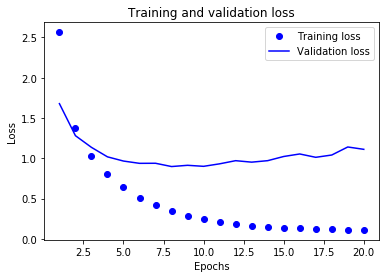

In [37]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

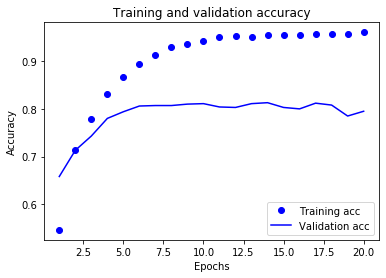

In [38]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Since we overfit at about nine or so epochs, re-train w/ only that many.

In [39]:
model.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
results

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 65us/step - loss: 0.1077 - accuracy: 0.9583 - val_loss: 1.0863 - val_accuracy: 0.8040
Epoch 2/9
7982/7982 [==============================] - 0s 62us/step - loss: 0.1071 - accuracy: 0.9580 - val_loss: 1.1006 - val_accuracy: 0.8010
Epoch 3/9
7982/7982 [==============================] - 0s 61us/step - loss: 0.1035 - accuracy: 0.9599 - val_loss: 1.1376 - val_accuracy: 0.8020
Epoch 4/9
7982/7982 [==============================] - 0s 62us/step - loss: 0.1097 - accuracy: 0.9554 - val_loss: 1.0939 - val_accuracy: 0.8070
Epoch 5/9
7982/7982 [==============================] - 0s 61us/step - loss: 0.1017 - accuracy: 0.9592 - val_loss: 1.1741 - val_accuracy: 0.7900
Epoch 6/9
7982/7982 [==============================] - 0s 63us/step - loss: 0.0984 - accuracy: 0.9587 - val_loss: 1.1318 - val_accuracy: 0.8120
Epoch 7/9
7982/7982 [==============================] - 0s 61us/step - loss: 0.1042 - acc

[1.4112228447055561, 0.784060537815094]

How is the 78% accuracy compared to just assigning a label at random? This is a multiclass classification problem, so we can't use the shortcut that in a binary classification problem w/ balanced output (labels are 50/50 true and false) we'd get 50% accuracy.

In [40]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.17853962600178094

So with this data we'd expect about a 18% accuracy if we output labels at random. 78% is decent compared to a baseline of 18%.

In [41]:
predictions = model.predict(x_test)
predictions.shape

(2246, 46)

In [42]:
predictions[0].shape

(46,)

In [43]:
predictions[0]

array([3.63744363e-07, 8.78703474e-07, 4.56143425e-08, 9.59239602e-01,
       3.61099653e-02, 4.35618048e-08, 1.02382054e-10, 1.17823731e-06,
       6.68070337e-04, 6.52145218e-08, 7.34730975e-06, 1.59029674e-04,
       3.73317016e-06, 2.45551678e-06, 1.99990652e-07, 1.98377231e-10,
       1.65179488e-04, 2.21731185e-07, 5.40380654e-07, 2.24315270e-04,
       3.31235072e-03, 3.13082114e-06, 1.86648364e-07, 6.03363958e-07,
       3.04641787e-07, 5.89121107e-09, 3.17662494e-11, 2.36045317e-09,
       4.58168142e-06, 2.68052304e-07, 3.18615821e-05, 1.67140798e-11,
       2.44391401e-07, 7.88479670e-10, 5.11778069e-08, 1.59502314e-08,
       6.28081107e-05, 5.89471849e-09, 1.01362509e-07, 3.82202181e-09,
       9.67559632e-09, 3.90272561e-08, 1.45545457e-12, 8.36138980e-08,
       3.04326390e-11, 2.57356203e-09], dtype=float32)

So we have the probability for each of the 46 classes, and all should sum to 1.

In [45]:
np.sum(predictions[0])

0.9999999

The index associated w/ the largest probability is the class we predict.

In [46]:
np.argmax(predictions[0])

3

# House prices - regression

In [18]:
from keras.datasets import boston_housing

In [19]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

train_data.shape, train_targets.shape, test_data.shape, test_targets.shape

((404, 13), (404,), (102, 13), (102,))

In [20]:
train_data[:3]

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, 0.00000e+00, 5.38000e-01,
        6.14200e+00, 9.17000e+01, 3.97690e+00, 4.00000e+00, 3.07000e+02,
        2.10000e+01, 3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, 0.00000e+00, 4.15000e-01,
        7.61000e+00, 1.57000e+01, 6.27000e+00, 2.00000e+00, 3.48000e+02,
        1.47000e+01, 3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, 0.00000e+00, 6.31000e-01,
        4.97000e+00, 1.00000e+02, 1.33250e+00, 2.40000e+01, 6.66000e+02,
        2.02000e+01, 3.75520e+02, 3.26000e+00]])

In [21]:
train_targets[:3]

array([15.2, 42.3, 50. ])

The 13 different features are on different scales - we want to normalize so they're all on the same scale. 

In [22]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [23]:
train_data.shape[1]

13

MAE is mean absolute error - the absolute value of the difference between the predictions and the targets. Since the targets are in 1000s, an MAE of 0.5 means the predictions are off - different from the actual - by $500 on average.

In [24]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

K-fold validation, manually.

In [25]:
404 // 4

101

In [29]:
k = 4
num_val_samples = len(train_data) // k  # integer division, dropping the remainder - so 404 / 4 = 101 as an int and not a float
num_epochs = 100
all_scores = []

for i in range(k):
    print(f'processing fold #{i}')
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis = 0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold #0
processing fold #1
processing fold #2
processing fold #3


In [30]:
all_scores

[2.047067880630493, 2.697765588760376, 2.716614007949829, 2.386223793029785]

In [31]:
np.mean(all_scores)

2.461917817592621

So, the amount we're off by ranges from $2014 to $2716. On average, we're off by $2500.

Try training w/ 500 epochs, and save the per-epoch validation score log each time, so we can afterwards compute the per-epoch MAE scores for all folds.

In [37]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print(f'processing fold #{i}')
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold #0
processing fold #1
processing fold #2
processing fold #3


Calc the MAE per epoch, using data from each of the four folds - i.e., each time we take the avg of four values, one from each fold.

In [39]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_mae_history

[4.692938327789307,
 3.4186081886291504,
 2.990828216075897,
 2.728807270526886,
 2.693298876285553,
 2.6728198528289795,
 2.755679190158844,
 2.652045488357544,
 2.4960122406482697,
 2.52271831035614,
 2.5134387612342834,
 2.595883846282959,
 2.6407458186149597,
 2.5344961881637573,
 2.439022332429886,
 2.4497699439525604,
 2.4246319234371185,
 2.4648848176002502,
 2.440561443567276,
 2.5062309205532074,
 2.340407282114029,
 2.320247083902359,
 2.3708947002887726,
 2.54998379945755,
 2.500167429447174,
 2.439067006111145,
 2.3729367554187775,
 2.44175723195076,
 2.359359323978424,
 2.4594337344169617,
 2.44543993473053,
 2.4838287830352783,
 2.376785159111023,
 2.3640352487564087,
 2.4029852151870728,
 2.2965541183948517,
 2.4975041151046753,
 2.502075672149658,
 2.3067327737808228,
 2.2950820922851562,
 2.247885584831238,
 2.4792044162750244,
 2.296993851661682,
 2.608494281768799,
 2.3648293018341064,
 2.3073626458644867,
 2.414969325065613,
 2.2403628826141357,
 2.4157434701919556,

Text(0, 0.5, 'Validation MAE')

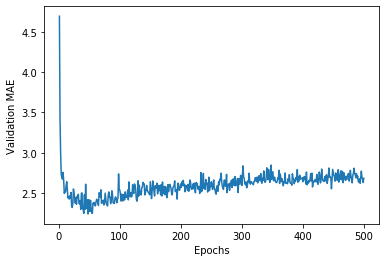

In [40]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

Most of the vertical distance ends up being for just the first few epochs when we get a lot of improvement, and then even after that there's a lot of variance. We'll get a plot that's easier to use by omitting the first 10 epochs and by smoothing the output using an exponental moving average. 

Text(0, 0.5, 'Validation MAE')

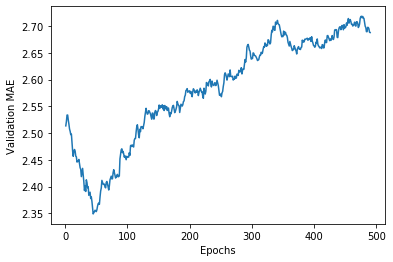

In [41]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
            
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:]) # here's were we omit the first 10

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

So, we start overfitting at about 50-60 epochs. Let's train a final model there, using all of the data.

In [45]:
model = build_model()
model.fit(train_data, train_targets, epochs=60, batch_size=16)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

Epoch 1/60
404/404 [==============================] - 0s 294us/step - loss: 497.2815 - mae: 20.3047
Epoch 2/60
404/404 [==============================] - 0s 144us/step - loss: 326.8771 - mae: 15.8028
Epoch 3/60
404/404 [==============================] - 0s 161us/step - loss: 159.4850 - mae: 10.3382
Epoch 4/60
404/404 [==============================] - 0s 138us/step - loss: 71.1586 - mae: 6.3697
Epoch 5/60
404/404 [==============================] - 0s 144us/step - loss: 41.2801 - mae: 4.5942
Epoch 6/60
404/404 [==============================] - 0s 147us/step - loss: 27.9132 - mae: 3.6617
Epoch 7/60
404/404 [==============================] - 0s 146us/step - loss: 22.2807 - mae: 3.2476
Epoch 8/60
404/404 [==============================] - 0s 151us/step - loss: 19.1742 - mae: 2.9605
Epoch 9/60
404/404 [==============================] - 0s 156us/step - loss: 16.9281 - mae: 2.7825
Epoch 10/60
404/404 [==============================] - 0s 144us/step - loss: 15.6584 - mae: 2.6715
Epoch 11/60
4

2.6405296325683594